# fast.ai test notebook
This notebook contains the training test with fast.ai. \
This notebook is the spiritual successor to a kaggle tutorial on how to use fast.ai by Chris Wallenwein, updated to remove deprecated functions and for simplicity. \
The code can run using GPU computing, though the original code run on Mac does not include it. \
As a reminder, this library is not optimised for Mac so the run times shown here are exaggeratedly high compared to how it should ideally run, as an example: using a Linux machine with GPU computing, the training of this model for 5 epochs takes around 7 minutes, whereas 5 epochs on Mac without GPU takes about 50 minutes. 

In this version of the notebook, the CSV files have been cut to hold 10'000 instead of 42'000 training datapoints, and 5'000 instead of 28'000 datapoints. This allows the code to not take 58 minutes to run, and also fit the files into GitHub's 25MB limit.

In [1]:
# Requirements:

!pip3 install torch torchvision fastai pandas random matplotlib os pathlib numpy

In [2]:
import fastai
from fastai import *
from fastai.vision.all import *

import os
from pathlib import Path
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt   
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [3]:
# Here goes the path for the input train and test .csv files.
INPUT = "Training/fastai/input"
# or = Path("../input/digit-recognizer")
print(os.listdir(INPUT))

# Reading the datasets
train_df = pd.read_csv(INPUT + "/train.csv")
test_df = pd.read_csv(INPUT + "/test.csv")

# To get an idea of what the .csv files look like let's view the first few rows.
# Note that the first row is an index and the first column of the training data corresponds to the label (our y).
train_df.head(3)


['.DS_Store', 'test.csv', 'train.csv']


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Since we are testin fast.ai's Computer Vision functionalities, we need the data to come as individual .jpg images instead of a unified .csv file. \
To start off the data sorting and converting process, the folder structure used by fast.ai should be created first.

In [4]:
# Creating the folder structure used by fast.ai
TRAIN = Path("../train")
TEST = Path("../test")

# Creating the training directory:
for i in range(10):
    try:
        os.makedirs(TRAIN/str(i))
    except:
        pass

print(sorted(os.listdir(TRAIN)))

# Creating the testing directory:
try:
    os.makedirs(TEST)
except:
    pass

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


Once the folder structure is complete, all the handwritten digit data needs to be separated into images, from the (1 x 784) rows in the input files to (28 x 28) pixel images. \
To achieve this we can use PIL. 

The first time this code is run, the saving process will take some time, a few minutes or so. Write something nice to a friend whilst you wait.

In [5]:
# Moving .csv inputs to individual .jpg files
from PIL import Image

def saveDigit(digit, filepath):
    digit = digit.reshape(28,28)
    digit = digit.astype(np.uint8)
    img = Image.fromarray(digit)
    img.save(filepath)

# Saving training images:
for index, row in train_df.iterrows():
    # We specify the label so as to save each image according to the digit it represents
    label, digit = row[0], row[1:]
    folder = TRAIN/str(label)
    filename = f"{index}.jpg"
    filepath = folder/filename
    digit = digit.values
    saveDigit(digit, filepath)

# Saving testing images:
for index, digit in test_df.iterrows():
    # Here we do not separate the testing data into folders, so the saing process is a little more straightforward
    folder = TEST
    filename = f"{index}.jpg"
    filepath = folder/filename
    digit = digit.values
    saveDigit(digit, filepath)

# The different saving of the training data is because 

Here is some of the training data:


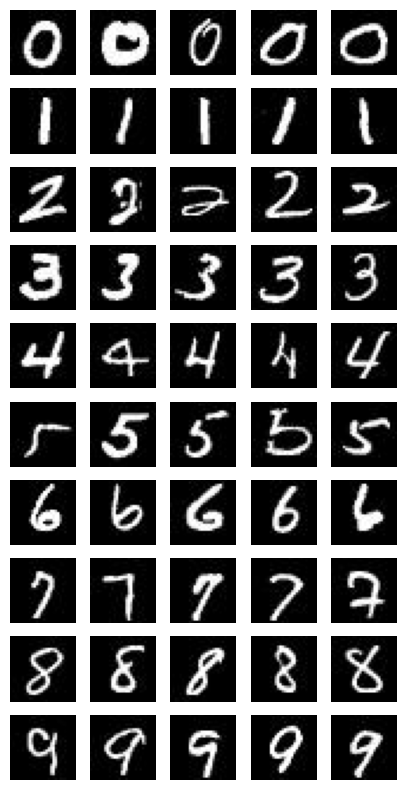

In [6]:
# Visualise the dataset by looking at some of the input images. First, the training data
fig = plt.figure(figsize=(5,10))
for rowIndex in range(0, 10):
    subdirectory = str(rowIndex)
    path = TRAIN/subdirectory
    images = os.listdir(path)
    for sampleIndex in range(1, 6):
        randomNumber = random.randint(0, len(images)-1)
        image = Image.open(path/images[randomNumber])
        ax = fig.add_subplot(10, 5, 5*rowIndex + sampleIndex)
        ax.axis("off")
        
        plt.imshow(image, cmap='gray')
print("Here is some of the training data:")
plt.show()

Here is some of the testing data


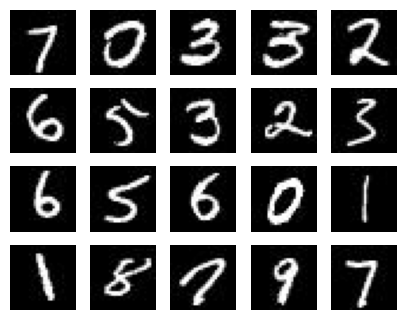

In [7]:
# Visualise some of the testing data as well
fig = plt.figure(figsize=(5, 10))
paths = os.listdir(TEST)
for i in range(1, 21):  
    # There is only one loop for the testing data, as it does not have to deal with the folder division.
    randomNumber = random.randint(0, len(paths)-1)
    image = Image.open(TEST/paths[randomNumber])
    ax = fig.add_subplot(10, 5, i)
    ax.axis("off")
    
    plt.imshow(image, cmap='gray')
print("Here is some of the testing data")
plt.show()

The data should be bundled together to be used in training the model, by using an ImageDataLoader (previsouly named DataBunch method), specifying the type and location of the data, along with some hyperparameters for use durin gtraining. Both the DataLoaders and the vision_learner used for model creation later have defaults set, so in this case we dont need to normalise the data as it will automatically be calculated and applied in before model training, nor do we need to worry about optimizer or loss functions etc. \
In the case of the DataLoader, we will specify the validation percentage (valid_pct) which determines how much of the training data will be set aside for accuracy validation each epoch, along with the batch size and image size.

In [8]:
# Applying a DataLoader to then pass the data into the mdoel according to fast.ai's model architecture.
# We can use the preset "from_folder" variant since we have saved all images in a folder system.
data = ImageDataLoaders.from_folder(
    path = TRAIN,
    test = TEST,
    valid_pct = 0.2,
    bs = 16,
    size = 28
)

Creating the CNN. \
There are some preset ResNet models with different sizes available, so we will use one of those - the smallest available, ResNet18. \
To create a CNN in fast.ai is not very complicated, we can call vision_learner and add into it our architecture, like the model and data and so forth. \
As previously mentioned, some of the hyperparameters are already set by default to work with generic computer vision models.

In [9]:
learn = vision_learner(data, arch = models.resnet18, metrics = accuracy, model_dir = "/tmp/models", lr = 0.01)

/usr/local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
# Fitting the model:
learn.fit_one_cycle(n_epoch = 5)

epoch,train_loss,valid_loss,accuracy,time
0,1.138702,0.639105,0.000000,01:39
1,0.658958,0.261598,0.000000,01:34
2,0.325579,0.151619,0.000000,01:33
3,0.287137,0.134267,0.000000,01:35
4,0.202665,0.101055,0.000000,01:34


Once the model has been trained it needs to be evaluated, so let's use one of fast.ai's methods and create a classification object. \
For some insight into the model's workings, let's also use some preset functions to view the datapoints that performed the worst during evaluation.

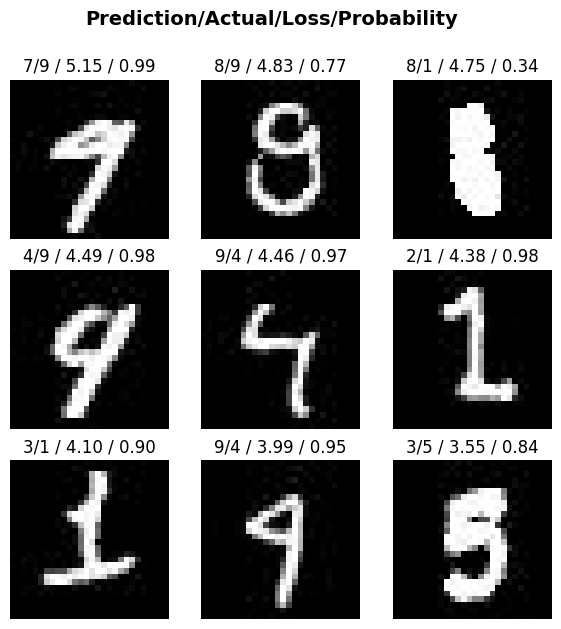

In [11]:
# This is to create a classification object to evaluate the model
interp = ClassificationInterpretation.from_learner(learn)

# These are the 9 items with the highest loss
interp.plot_top_losses(9, figsize=(7, 7))

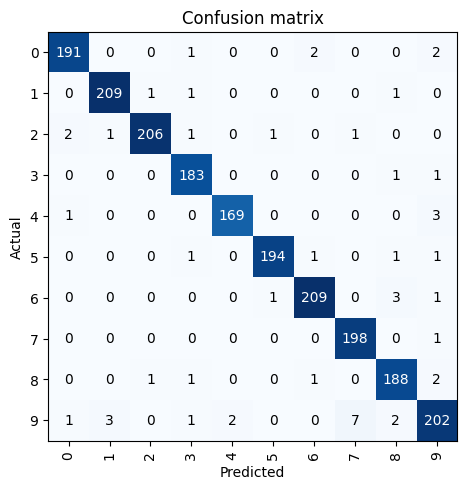

In [12]:
# Lastly, creating a confusion matrix to visualise where the most errors occur and how accurate the model is:
interp.plot_confusion_matrix()

The model's accuracy at evaluation is 0.975.